# Tutorial BPR con Implicit II

MAN 3160 - Sistemas Recomendadores

En este tutorial vamos revisar cómo afectan los hiperparámetros en el rendimiento de un método BPR.


## Importar Librerías

In [1]:
# Instalamos librerías para descarcar y descomprimir archivos.

!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse

C:\Users\alfi9\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Entrenamiento de agente

In [3]:
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip


Saved under ml-100k (11).zip


In [4]:
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [5]:
dir_train = 'ml-100k'

# Generamos los títulos de las columnas del archivo items.

columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv(f'{dir_train}/u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

In [7]:
# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >= 3 else 0 for x in df_train.rating ]

In [8]:
# Cargamos el dataset con los items
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

In [9]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[3]:
        if row[1] not in user_items:
            user_items[row[1]] = []

        user_items[row[1]].append(row[2])
        itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

user_item_matrix = sparse.csr_matrix(sparse_matrix)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
items_ids = {key: i for i, key in enumerate(itemset)}

In [10]:
# Cargamos el dataset de testing
df_test = pd.read_csv(f'{dir_train}/u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[3] and row[1] in user_items: # Solo tomamos filas con rating (row[3]) = 1 y usuarios que tengan interacciones en el set de entrenamiento
        if row[1] not in user_items_test:
            user_items_test[row[1]] = []

        user_items_test[row[1]].append(row[2])

In [11]:

model_bpr = implicit.bpr.BayesianPersonalizedRanking()
model_bpr.fit(user_item_matrix)

100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 165.14it/s, train_auc=89.15%, skipped=23.09%]


### Métricas

In [12]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [13]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']

## Evaluación del modelo

In [15]:
for n in [5, 10, 15, 20]:
    mmap, ndcg = evaluate_model(model_bpr, n)
    print(f'map@{n}: {mmap} \nndcg@{n}: {ndcg}')

map@5: 0.5126260683760677 
ndcg@5: 0.7523076923076923
map@10: 0.4710524182607519 
ndcg@10: 0.8707692307692307
map@15: 0.43530134765281264 
ndcg@15: 0.9
map@20: 0.4108770000943975 
ndcg@20: 0.9353846153846154


## Ajuste de hiperparámetros

https://benfred.github.io/implicit/api/models/cpu/bpr.html

In [16]:
factores = [i*5 for i in range(1, 15)]
iteraciones = [i*10 for i in range(1, 15)]

map_f = []
ndcg_f = []

map_it = []
ndcg_it = []

for f in factores:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f)
    model_bpr.fit(user_item_matrix)
    mmap, ndcg = evaluate_model(model_bpr, 10)
    map_f.append(mmap)
    ndcg_f.append(ndcg)
    
for it in iteraciones:
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(iterations=it)
    model_bpr.fit(user_item_matrix)
    mmap, ndcg = evaluate_model(model_bpr, 10)
    map_it.append(mmap)
    ndcg_it.append(ndcg)


100%|█████████████████████████████████████████████| 140/140 [00:00<00:00, 143.57it/s, train_auc=94.17%, skipped=22.68%]


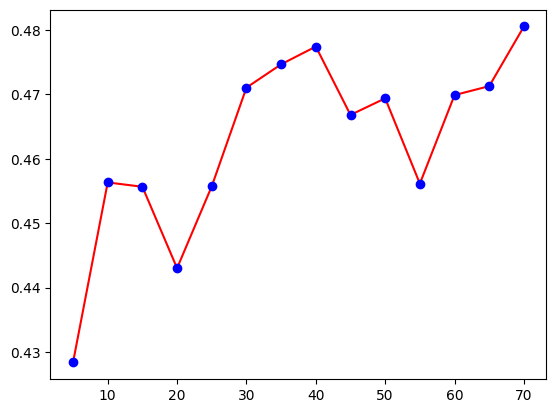

In [17]:
plt.plot(factores, map_f, 'r-')
plt.plot(factores, map_f, 'bo')
plt.show()

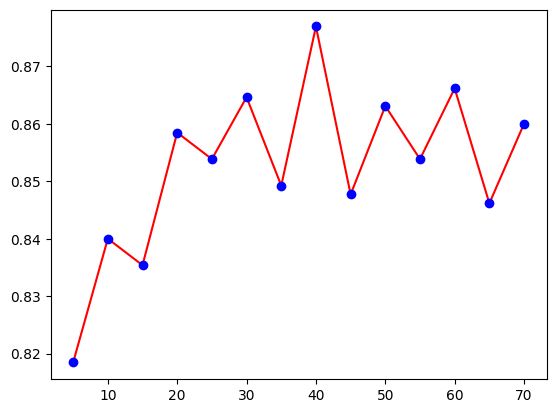

In [18]:
plt.plot(factores, ndcg_f, 'r-')
plt.plot(factores, ndcg_f, 'bo')
plt.show()

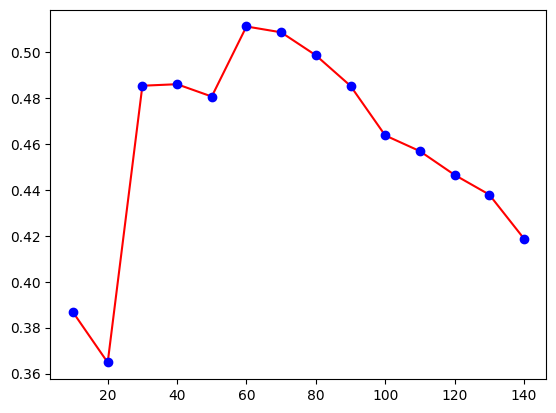

In [19]:
plt.plot(iteraciones, map_it, 'r-')
plt.plot(iteraciones, map_it, 'bo')
plt.show()

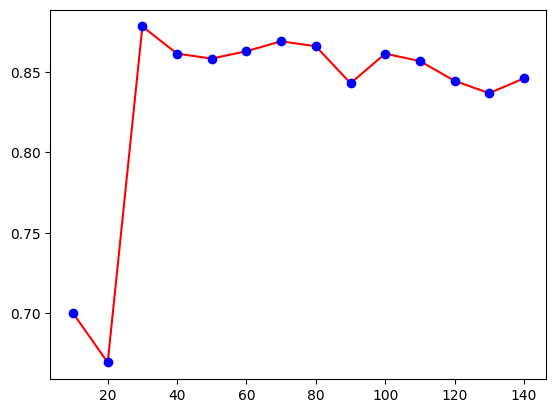

In [20]:
plt.plot(iteraciones, ndcg_it, 'r-')
plt.plot(iteraciones, ndcg_it, 'bo')
plt.show()